# Onset detection

In this tutorial, we will look at how to perform [onset](https://en.wikipedia.org/wiki/Onset_(audio)) detection and mark onset positions in the audio.

Onset detection consists of two steps:

- Compute an onset detection function (ODF). ODFs describe changes in the audio signal capturing frame-to-frame spectral energy or phase differences. The peaks of an ODF correspond to abrupt changes, and they may represent occurring onsets.

- Decide onset locations in the signal based on the peaks in the computed ODF. Depending on your application, you can try combining different ODFs for more refined results.

[OnsetDetection](http://essentia.upf.edu/documentation/reference/std_OnsetDetection.html) estimates various ODFs for an audio frame given its spectrum. It should be called iteratively on consequent frames one by one as it remembers the previously seen frame to compute the difference. [OnsetDetectionGlobal](https://essentia.upf.edu/reference/std_OnsetDetectionGlobal.html) allows to compute a few more ODFs, and instead, it works on the entire audio signal as an input.

[Onsets](http://essentia.upf.edu/documentation/reference/std_Onsets.html) detects onsets given a matrix with ODF values in each frame.  It can be used with a single or multiple ODFs.

In case you want to sonify detected onsets, use [AudioOnsetsMarker](http://essentia.upf.edu/documentation/reference/std_AudioOnsetsMarker.html) to add beeps or pulses to the mono audio at onset positions. Alternatively, we can store both the original sound and the beeps in a stereo signal putting them separately into left and right channels using [StereoMuxer](http://essentia.upf.edu/documentation/reference/std_StereoMuxer.html). It is useful when you want to avoid masking the audio with the added markers (e.g., added beeps are masking hi-hats).

To save the audio to file, use [MonoWriter](https://essentia.upf.edu/reference/std_MonoWriter.html) or [AudioWriter](http://essentia.upf.edu/documentation/reference/std_AudioWriter.html).


Let's use two ODFs as an example and compare the detected onsets.

In [1]:
from essentia.standard import *
from tempfile import TemporaryDirectory


# Load audio file.
audio = MonoLoader(filename='../../../test/audio/recorded/hiphop.mp3')()

# 1. Compute the onset detection function (ODF).

# The OnsetDetection algorithm provides various ODFs.
od_hfc = OnsetDetection(method='hfc')
od_complex = OnsetDetection(method='complex')

# We need the auxilary algorithms to compute magnitude and phase.
w = Windowing(type='hann')
fft = FFT() # Outputs a complex FFT vector.
c2p = CartesianToPolar() # Converts it into a pair of magnitude and phase vectors.

# Compute both ODF frame by frame. Store results to a Pool.
pool = essentia.Pool()
for frame in FrameGenerator(audio, frameSize=1024, hopSize=512):
    magnitude, phase = c2p(fft(w(frame)))
    pool.add('odf.hfc', od_hfc(magnitude, phase))
    pool.add('odf.complex', od_complex(magnitude, phase))

# 2. Detect onset locations.
onsets = Onsets()

onsets_hfc = onsets(# This algorithm expects a matrix, not a vector.
                    essentia.array([pool['odf.hfc']]),
                    # You need to specify weights, but if we use only one ODF
                    # it doesn't actually matter which weight to give it
                    [1])

onsets_complex = onsets(essentia.array([pool['odf.complex']]), [1])


# Add onset markers to the audio and save it to a file.
# We use beeps instead of white noise and stereo signal as it's more distinctive.

# We want to keep beeps in a separate audio channel.
# Add them to a silent audio and use the original audio as another channel. Mux both into a stereo signal.
silence = [0.] * len(audio)

beeps_hfc = AudioOnsetsMarker(onsets=onsets_hfc, type='beep')(silence)
beeps_complex = AudioOnsetsMarker(onsets=onsets_complex, type='beep')(silence)

audio_hfc = StereoMuxer()(audio, beeps_hfc)
audio_complex = StereoMuxer()(audio, beeps_complex)

# Write audio to files in a temporary directory.
temp_dir = TemporaryDirectory()
AudioWriter(filename=temp_dir.name + '/hiphop_onsets_hfc_stereo.mp3', format='mp3')(audio_hfc)
AudioWriter(filename=temp_dir.name + '/hiphop_onsets_complex_stereo.mp3', format='mp3')(audio_complex)

We can now listen to the resulting audio files to see which of the two onset detection functions works better for our audio example.

In [2]:
import IPython
IPython.display.Audio('../../../test/audio/recorded/hiphop.mp3')

In [3]:
IPython.display.Audio(temp_dir.name + '/hiphop_onsets_hfc_stereo.mp3')

In [4]:
IPython.display.Audio(temp_dir.name + '/hiphop_onsets_complex_stereo.mp3')

Finally, let's plot the onset detection functions we computed and the audio with onsets marked by vertical lines. Inspecting these plots, we can easily see how the `hfc` method picked up the hi-hats, while the `complex` method also detected the kicks.

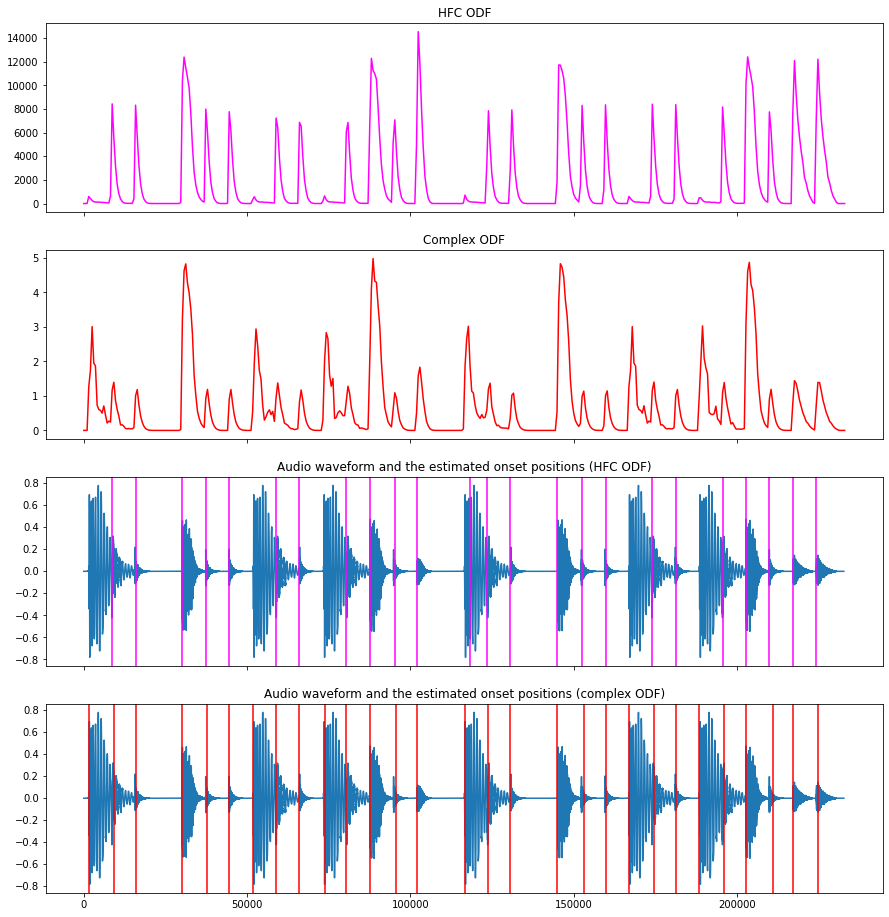

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy
n_frames = len(pool['odf.hfc'])
frames_position_samples = numpy.array(range(n_frames)) * 512

fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(4, 1, sharex=True, sharey=False, figsize=(15, 16))

ax1.set_title('HFC ODF')
ax1.plot(frames_position_samples, pool['odf.hfc'], color='magenta')

ax2.set_title('Complex ODF')
ax2.plot(frames_position_samples, pool['odf.complex'], color='red')

ax3.set_title('Audio waveform and the estimated onset positions (HFC ODF)')
ax3.plot(audio)
for onset in onsets_hfc:
    ax3.axvline(x=onset*44100, color='magenta')

ax4.set_title('Audio waveform and the estimated onset positions (complex ODF)')
ax4.plot(audio)
for onset in onsets_complex:
    ax4.axvline(x=onset*44100, color='red')
